In [2]:
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
import json
import os

In [3]:
LABELS = ['sample_sha1', 'unpacked_sample_sha1', 'unpacked_sample_id', 'packed', 'packer_name', 'source', 'benign',
          'malicious', 'similarity', 'benign_vt', 'malicious_vt', 'dpi_cmpx', 'corrupted', 'most_similar_sha1',
          'unpacked_similarity', 'packed_static_manalyze']

In [4]:
def load(files):
    dfs = []
    for file in files:
        with open(file, 'rb') as f:
            dfs.append(pickle.load(f))

    return dfs

In [5]:
def label_encode(df):
    for col in df.columns:
        if df[col].dtype == object:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
    return df

In [21]:
def split(dfs, drop=LABELS, test='malicious', test_size=0.3):
    df = pd.concat(dfs, ignore_index=True)

    ignore = "a1ecbc7cd423261cad213c55747e2708108e534f 5e1d5aaf3b7ec7c7ea6aa819fdbcdadec3d6c8b8 ea53caef85a78bd7cd93affd341d1f56bc1c56f8 f9639b3447b1c4d4a11af1138b5a652cdf29b95d 8bc2018789ead76b5c8c1431ad7941afb5afa918".split()
    df = df[~df['sample_sha1'].isin(ignore)]

    x = df.drop(drop, axis=1, errors='ignore')
    x = label_encode(x)

    y = df[test]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

    return x_train, x_test, y_train, y_test

In [7]:
def train(x_train, y_train):
    rf = RandomForestClassifier()
    rf.fit(x_train, y_train)
    return rf

In [8]:
def predict(rf, x_test):
    y_pred = rf.predict(x_test)
    return y_pred

In [9]:
def assess(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)

In [10]:
def plot(rf, x_test, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

    RocCurveDisplay.from_estimator(rf, x_test, y_test)

In [11]:
dfs = load(['bp.pickle', 'bu.pickle', 'mp.pickle'])
df = pd.concat(dfs, ignore_index=True)
ignore = "a1ecbc7cd423261cad213c55747e2708108e534f ea53caef85a78bd7cd93affd341d1f56bc1c56f8 f9639b3447b1c4d4a11af1138b5a652cdf29b95d 8bc2018789ead76b5c8c1431ad7941afb5afa918".split()
df = df[~df['sample_sha1'].isin(ignore)]
df.to_pickle('static.pickle')

Accuracy: 0.8896321070234113
Precision: 0.8819875776397516
Recall: 0.9102564102564102


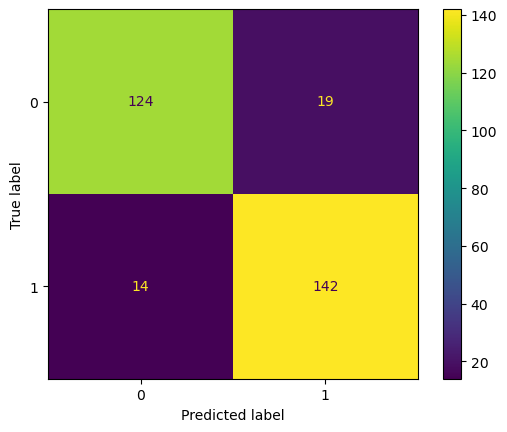

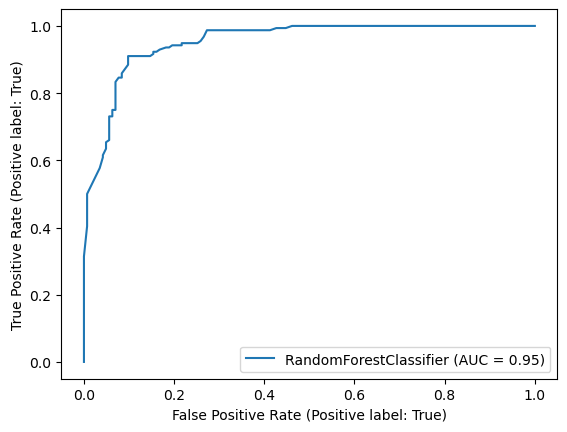

In [22]:
dfs = load(['bp.pickle', 'bu.pickle', 'mp.pickle'])
x_train, x_test, y_train, y_test = split(dfs)
rf = train(x_train, y_train)
y_pred = predict(rf, x_test)
assess(y_test, y_pred)
plot(rf, x_test, y_test, y_pred)

In [12]:
sigs = set()

for file in os.listdir("reports"):
    if "json" not in file:
        continue
    
    with open(f"reports/{file}") as f:
        r = json.load(f)
        
    for sig in r['signatures']:
        sigs.add(sig['name'])

print(sigs)

{'registry_antivm_ide_disks', 'loads_driver', 'cmd_sc_create', 'file_drops_system32', 'registry_write_runkey', 'registry_file_extension_vis', 'thread_hidefromdebugger', 'process_other_parent', 'registry_writes_large_value', 'cmd_attrib_hidden', 'file_drops_startup', 'registry_winlogon_persistence', 'files_drops_exe_user', 'susevent_adjustprivilegetoken', 'registry_disables_cmd', 'registry_antivm_cpu_check', 'registry_modifies_browser_warnings', 'registry_sets_ie_homepage', 'registry_disables_auto_update', 'antianalysis_debugger_devices', 'cmd_sc_stop', 'loads_dropped_dll', 'registry_creates_ie_bho', 'xmrig', 'registry_modifies_browser_security', 'files_creates_shortcut', 'wrote_proc_memory', 'cmd_sc_config', 'registry_disables_regedit', 'infostealer_ftp_data', 'cmd_schtasks_create', 'cmd_sc_autostart', 'deletes_shadow_copies', 'registry_antivm_bios_check', 'registry_checks_nation_code', 'cmd_sc_start', 'process_injection', 'registry_modifies_file_vis', 'susevent_mapviewofsection', 'reg

In [13]:
dfs = load(['bp.pickle', 'bu.pickle', 'mp.pickle'])
df = pd.concat(dfs, ignore_index=True)

a = {}
for sig in sigs:
    a[sig] = [False for i in range(996)]
a['malicious'] = [False for i in range(996)]
a['sample_sha1'] = ["" for i in range(996)]

i = 0
for file in os.listdir("reports"):
    if "json" not in file or "2ba6e5cb1df3ecf1d0dadf15d09e33f97556ea90" in file:
        continue
    
    with open(f"reports/{file}") as f:
        r = json.load(f)
    
    s = []
    for si in r['signatures']:
        s.append(si['name'])
    
    for sig in sigs:
        if sig in s:
            a[sig][i] = True

    sha1 = file[:-5]
    a['sample_sha1'][i] = sha1
    
    a['malicious'][i] = df.loc[df['sample_sha1'] == sha1].iloc[0]['malicious']
    i += 1

dynamic = pd.DataFrame(a)

Accuracy: 0.7625418060200669
Precision: 0.8440366972477065
Recall: 0.6301369863013698


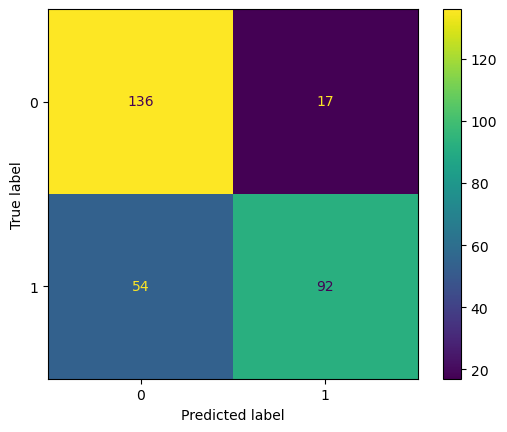

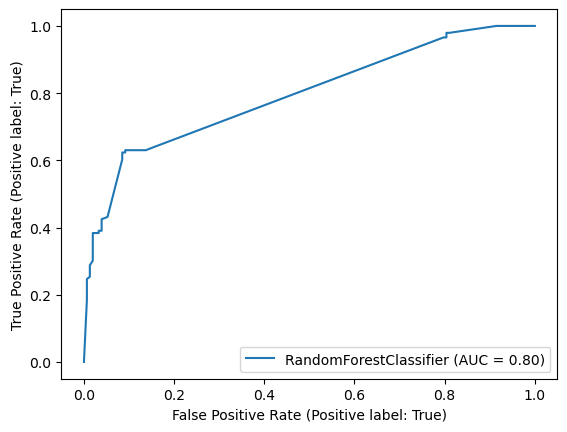

In [14]:
x_train, x_test, y_train, y_test = split([dynamic])
rf = train(x_train, y_train)
y_pred = predict(rf, x_test)
assess(y_test, y_pred)
plot(rf, x_test, y_test, y_pred)

In [37]:
hybrid = pd.concat(dfs, ignore_index=True)

ignore = "a1ecbc7cd423261cad213c55747e2708108e534f 5e1d5aaf3b7ec7c7ea6aa819fdbcdadec3d6c8b8 ea53caef85a78bd7cd93affd341d1f56bc1c56f8 f9639b3447b1c4d4a11af1138b5a652cdf29b95d 8bc2018789ead76b5c8c1431ad7941afb5afa918".split()
hybrid = hybrid[~hybrid['sample_sha1'].isin(ignore)]

a = {}
for sig in sigs:
    a[sig] = []

hybrid['sample_sha1']
for sha1 in hybrid['sample_sha1']:
    for sig in sigs:
        if len(dynamic.loc[dynamic['sample_sha1'] == sha1]) == 0:
            print(sha1)
        a[sig].append(dynamic.loc[dynamic['sample_sha1'] == sha1].iloc[0][sig])

for sig in sigs:
    hybrid[sig] = a[sig]

In [41]:
hybrid

,sample_sha1,benign,malicious,packed,unpacked_sample_sha1,unpacked_sample_id,packer_name,imp_setupremovefilelogentrya,imp_vardeccmp,imp_setdlgitemint,...,cmd_sc_config_disable,registry_disables_system_restore,registry_bypasses_windows_security,infostealer_browser_data,files_antiav_general,registry_bypasses_uac,file_drops_windows,registry_antivm_vmware,registry_modifies_firewall_policy,cmd_taskkill_process
0,54fc31e8206de903788e5481cac1314eb1e254a4,True,False,True,-1,-1,none,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1,5e584d3ce6526cd0a378e243290fd6206420e130,True,False,True,-1,-1,none,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,0d1a3ad3d2b1535d81e291cd06dd8fd878cab702,True,False,True,-1,-1,none,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,a6e85834139f51986b9d3a4d4721663e1c3b185b,True,False,True,-1,-1,none,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,f077b182d2ecf488d7e608f0ba6111a4794ceb16,True,False,True,-1,-1,none,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3adc5e26698c35f8c988acee42f835b06f64f34b,False,True,True,-1,-1,none,False,False,False,...,False,False,False,False,False,False,True,False,False,False
996,4f37a2dd8c046f222050e7cdfe1f601ed415ee8e,False,True,True,-1,-1,none,False,False,False,...,False,False,False,False,False,False,False,False,False,False
997,84c93cecbbc733161a4d0e442cb75192fe6a42ed,False,True,True,-1,-1,none,False,False,False,...,False,False,False,False,False,False,True,False,False,False
998,80a2097f63ac676888dc5feaf3435940bc65e05c,False,True,True,-1,-1,none,False,False,False,...,False,False,False,False,False,False,True,False,False,False


Accuracy: 0.882943143812709
Precision: 0.8904109589041096
Recall: 0.87248322147651


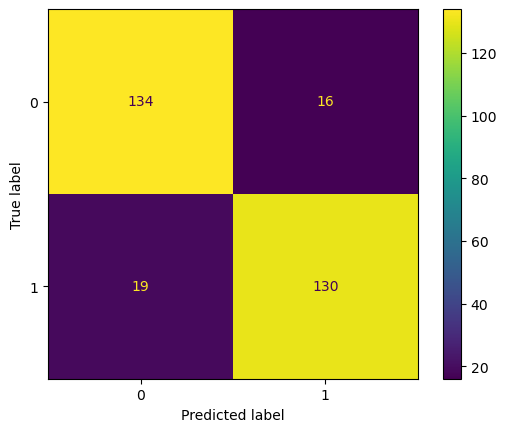

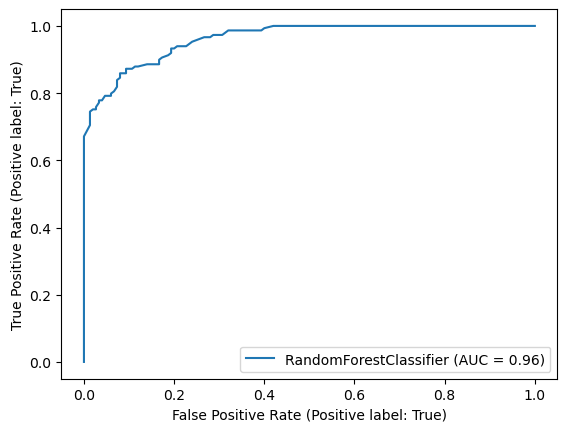

In [39]:
x_train, x_test, y_train, y_test = split([hybrid])
rf = train(x_train, y_train)
y_pred = predict(rf, x_test)
assess(y_test, y_pred)
plot(rf, x_test, y_test, y_pred)